# TP 04 : Evaluation et Sélection d’un modèle

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder , MinMaxScaler, StandardScaler, RobustScaler , PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


In [107]:
df=pd.read_csv('adult_data.csv', na_values=' ?')
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       30724 non-null  object
 2   education       32560 non-null  object
 3   education_num   32560 non-null  int64 
 4   marital_status  32560 non-null  object
 5   occupation      30717 non-null  object
 6   relationship    32560 non-null  object
 7   race            32560 non-null  object
 8   sex             32560 non-null  object
 9   capital_gain    32560 non-null  int64 
 10  capital_loss    32560 non-null  int64 
 11  hours_per_week  32560 non-null  int64 
 12  native_country  31977 non-null  object
 13  income          32560 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [56]:
df.dropna(inplace=True)

In [57]:
x=df.drop(['income','education'],axis=1)
y=df.income
y.value_counts()

 <=50K    22653
 >50K      7508
Name: income, dtype: int64

In [58]:
LE = LabelEncoder()
y = LE.fit_transform(y)
y = y.astype(int)
y = pd.DataFrame(y)
occurances = y.value_counts()

Text(0, 0.5, 'Occurances')

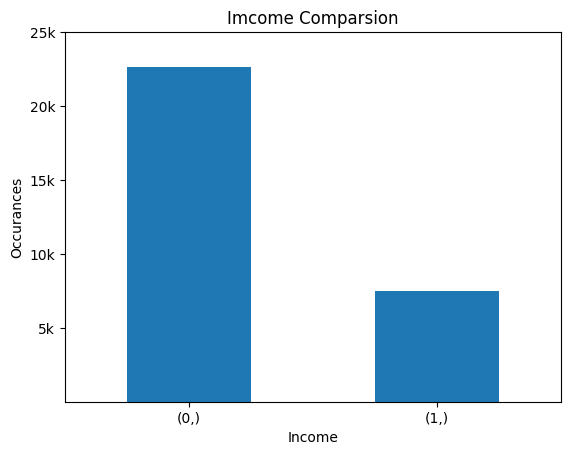

In [59]:
occurances.plot(kind='bar')
plt.title('Imcome Comparsion')
plt.xticks(rotation=0)
plt.xlabel('Income')
plt.yticks(np.arange(5000,25001,5000),['5k','10k','15k','20k','25k'])
plt.ylabel('Occurances') 

In [60]:
ros = RandomOverSampler(random_state=42)
x_ros, y_ros= ros.fit_resample(x, y)
occurances_ros = y_ros.value_counts()

Text(0, 0.5, 'Occurances')

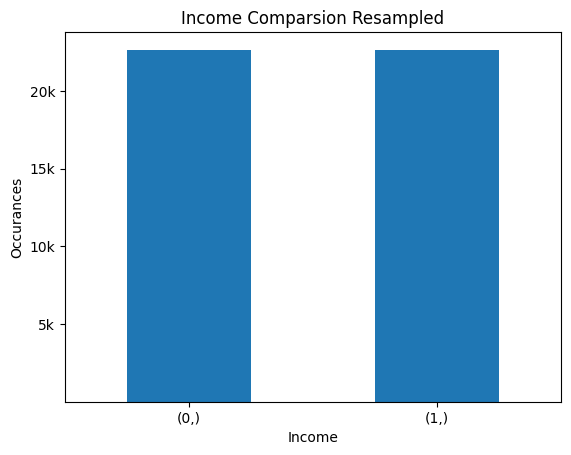

In [61]:
occurances_ros.plot(kind='bar')
plt.title('Income Comparsion Resampled')
plt.xticks(rotation=0)
plt.xlabel('Income')
plt.yticks(np.arange(5000,25000,5000),['5k','10k','15k','20k'])
plt.ylabel('Occurances') 

In [62]:
cols = x.columns
numerical_features = x._get_numeric_data().columns
categorical_features=list(set(cols) - set(numerical_features))
categorical_features,numerical_features

(['native_country',
  'occupation',
  'race',
  'marital_status',
  'workclass',
  'sex',
  'relationship'],
 Index(['age', 'education_num', 'capital_gain', 'capital_loss',
        'hours_per_week'],
       dtype='object'))

In [63]:
def plots(df, var, t):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])
    
    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0])

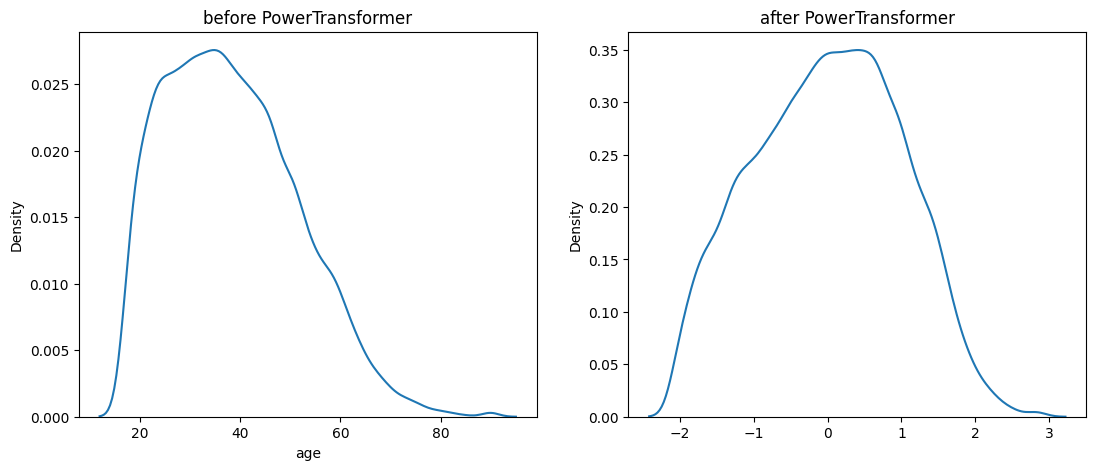

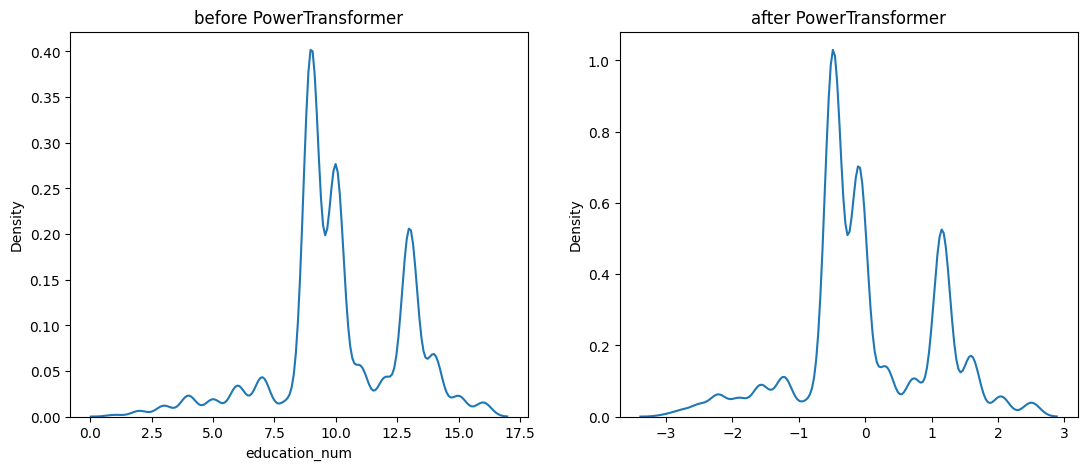

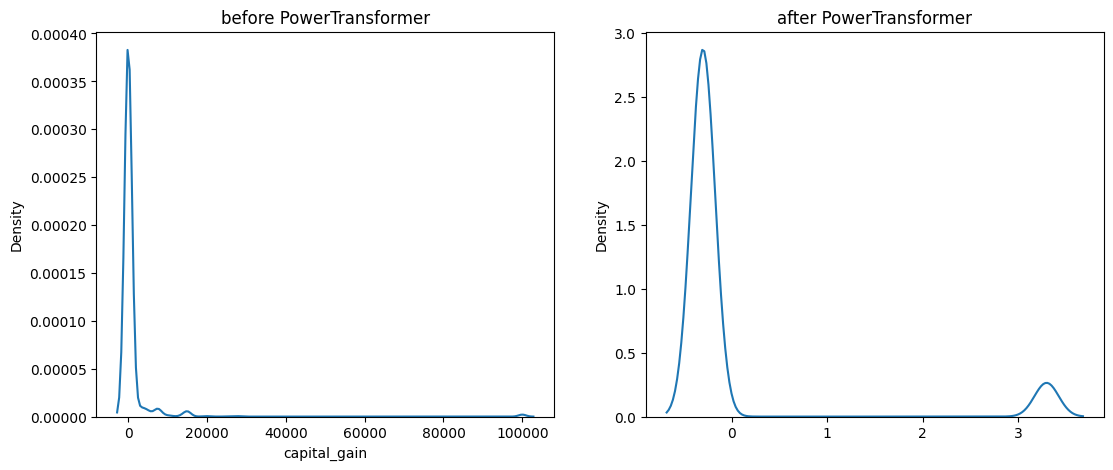

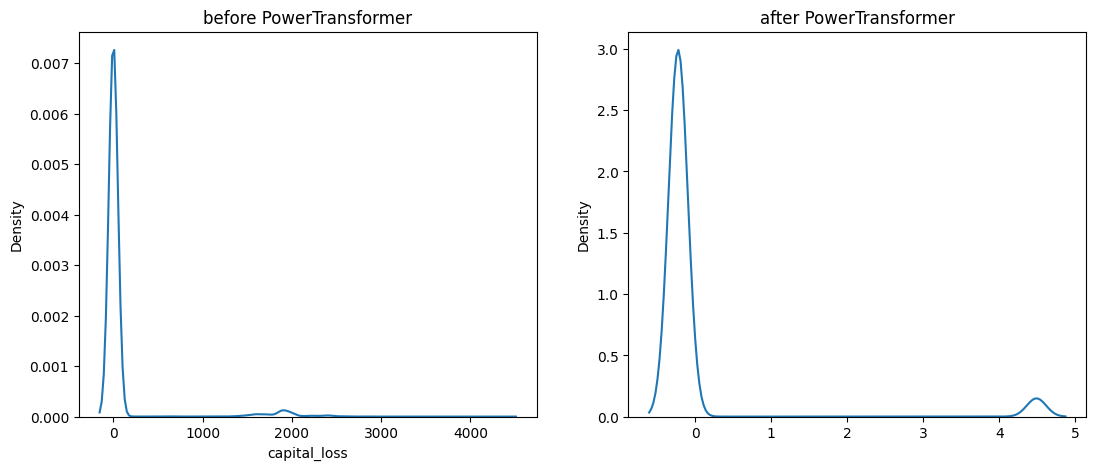

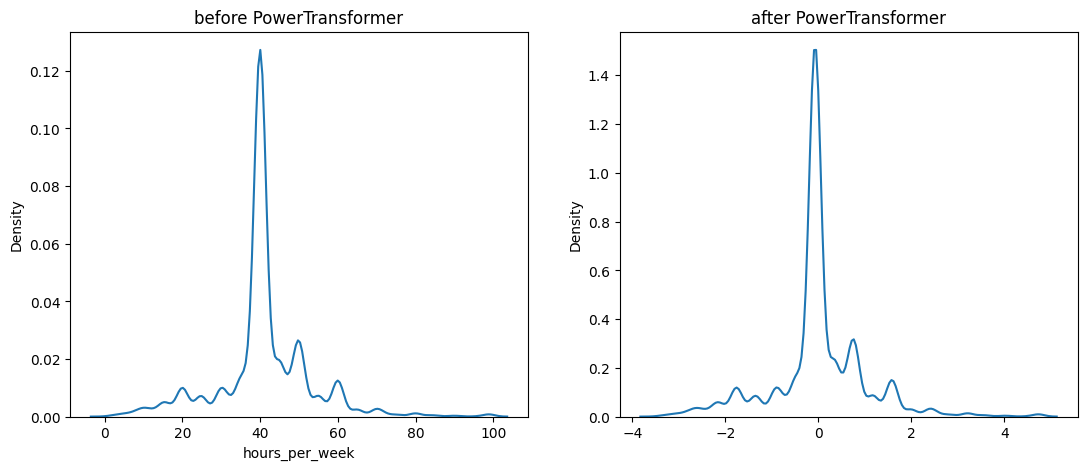

In [64]:
for col in df._get_numeric_data().columns:
    plots(df, col, PowerTransformer())

In [65]:
ct = ColumnTransformer([
    ('step1', PowerTransformer(), ['age',  'hours_per_week']),
    ('step2', StandardScaler(), ['capital_gain', 'capital_loss', 'education_num']),
    ('step3', OrdinalEncoder(), categorical_features)
])

In [66]:
p1 = Pipeline([
    ('coltf_step', ct),
    ('minmax', MinMaxScaler())
])

In [67]:
new_x=p1.fit_transform(x_ros)

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_x,y_ros, test_size = 0.2, random_state = 2)


## naive bayes Gaussian

In [91]:
# Train the Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# # Evaluate the performance of the model on the testing set
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6920105936879276


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [105]:
# Define the hyperparameter grid to search over
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Create a Gaussian Naive Bayes Classifier object
nb = GaussianNB()

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(nb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'var_smoothing': 1e-05}
Accuracy: 0.692451997351578


## arbre de decision

In [103]:
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

# Define the hyperparameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8996910174354447


## knn 

In [104]:
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create a KNN Classifier object
knn = KNeighborsClassifier()

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Best hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Accuracy: 0.8814831163098654


## xgboost

In [95]:


# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.8],
}

# Create an XGBoost Classifier object
xgb = XGBClassifier(random_state=42)

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(xgb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
Accuracy: 0.9130434782608695


## random forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
}

# Create a Random Forest Classifier object
rfc = RandomForestClassifier(random_state=42)

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9169057603178107
